## Step 1: Setup & Device (CUDA-aware)

In [1]:
import os
import sys
import types
import pandas as pd
import numpy as np
import torch
import pickle
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# ------------------------------------------------------------
# 1. Pandas backward-compatibility shim (Keep this)
# ------------------------------------------------------------
numeric_module = types.ModuleType("pandas.core.indexes.numeric")
class Int64Index(pd.Index): pass
numeric_module.Int64Index = Int64Index
sys.modules["pandas.core.indexes.numeric"] = numeric_module

# ------------------------------------------------------------
# 2. FIXED PATH SETUP (The Fix)
# ------------------------------------------------------------
# We must add "E:\Ignite Hack" to path, NOT "E:\Ignite Hack\src"
project_root = os.getcwd()

# Robust check: If running from a subfolder, move up until we find 'src'
if not os.path.exists(os.path.join(project_root, "src")):
    # Try going up one level (e.g., if inside 'notebooks/')
    project_root = os.path.abspath(os.path.join(project_root, ".."))

if project_root not in sys.path:
    sys.path.append(project_root)

print(f"[INFO] Project Root added to path: {project_root}")

# ------------------------------------------------------------
# 3. Import Project Modules
# ------------------------------------------------------------
try:
    from src.model import CNNMultiLabelECG
    from src.evaluate import evaluate_multilabel
    from src.ensemble import ensemble_predict
    from src.preprocessing import ECGPreprocessor
    print("[INFO] 'src' modules imported successfully!")
except ImportError as e:
    print(f"[ERROR] Import failed: {e}")
    print("Verify that your folder structure is: Project_Root -> src -> model.py")

[INFO] Project Root added to path: E:\Ignite Hack
[INFO] 'src' modules imported successfully!


## Step 2: Device Confirmation (Proof of CUDA)

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"[INFO] Using CUDA GPU: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("[INFO] Using Apple MPS")
else:
    device = torch.device("cpu")
    print("[WARNING] CPU only")

[INFO] Using CUDA GPU: NVIDIA GeForce RTX 2050


## Step 3: Validation Dataset Loader (Lazy, Safe)

In [3]:
# Define Validation Directory
VAL_DIR = r"E:\Ignite Hack\data\processed\val_split\250Hz\60s"

# Define Dataset Class
class LazyECGDataset(Dataset):
    def __init__(self, folder):
        self.folder = folder
        self.files = [f for f in os.listdir(folder) if f.endswith(".pk")]
        self.preprocessor = ECGPreprocessor() # Imported from src previously

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        with open(os.path.join(self.folder, self.files[idx]), "rb") as f:
            signal_df, label_dict = pickle.load(f)

        # Preprocess and ensure Float32
        sig = self.preprocessor.preprocess(signal_df.values.T.astype(np.float32))
        lbl = label_dict["classes_one_hot"].values.astype(np.float32)

        # Return Tensors
        return torch.tensor(sig), torch.tensor(lbl)

# Initialize Loader
val_dataset = LazyECGDataset(VAL_DIR)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)

print(f"[INFO] Validation Loader initialized with {len(val_dataset)} samples.")

[INFO] Validation Loader initialized with 1095 samples.


## Step 4: Load Trained Model (.pth)

In [4]:
MODEL_PATH = r"E:\Ignite Hack\ecg_model_v1.pth"

In [5]:
model = CNNMultiLabelECG(num_classes=9)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.to(device)
model.eval()

print("[INFO] Model loaded successfully")

C:\Users\Surya Teja\AppData\Local\Temp\ipykernel_10188\1621745547.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_locati

[INFO] Model loaded successfully


## Step 5: Inference without Ensemble

In [6]:
y_true, y_prob_single = [], []

with torch.no_grad():
    for X, y in tqdm(val_loader, desc="Single Model Inference"):
        X = X.to(device)
        preds = model(X).cpu().numpy()
        y_prob_single.append(preds)
        y_true.append(y.numpy())

y_true = np.vstack(y_true)
y_prob_single = np.vstack(y_prob_single)

metrics_single, aucs_single = evaluate_multilabel(y_true, y_prob_single)

metrics_single

Single Model Inference: 100%|██████████████████████████████████████████████████████████| 35/35 [00:09<00:00,  3.74it/s]


{'Best Threshold': np.float64(0.40000000000000013),
 'Hamming Loss': 0.043125317097919835,
 'Subset Accuracy': 0.7406392694063927,
 'F1 Macro': 0.772704168055433,
 'F1 Micro': 0.8238707003729797}

## Step 6: Inference with Ensemble

In [7]:
models = [model, model]  # same architecture, ensemble averaging

y_prob_ensemble = []

with torch.no_grad():
    for X, _ in tqdm(val_loader, desc="Ensemble Inference"):
        X = X.to(device)
        preds = ensemble_predict(models, X).cpu().numpy()
        y_prob_ensemble.append(preds)

y_prob_ensemble = np.vstack(y_prob_ensemble)

metrics_ensemble, aucs_ensemble = evaluate_multilabel(y_true, y_prob_ensemble)

metrics_ensemble

Ensemble Inference: 100%|██████████████████████████████████████████████████████████████| 35/35 [00:11<00:00,  3.16it/s]


{'Best Threshold': np.float64(0.40000000000000013),
 'Hamming Loss': 0.043125317097919835,
 'Subset Accuracy': 0.7406392694063927,
 'F1 Macro': 0.772704168055433,
 'F1 Micro': 0.8238707003729797}

## Step 7: Side-by-Side Metric Comparison

In [8]:
comparison = pd.DataFrame({
    "Metric": metrics_single.keys(),
    "Single Model": metrics_single.values(),
    "Ensemble Model": metrics_ensemble.values()
})

comparison

,Metric,Single Model,Ensemble Model
0,Best Threshold,0.400000,0.400000
1,Hamming Loss,0.043125,0.043125
2,Subset Accuracy,0.740639,0.740639
3,F1 Macro,0.772704,0.772704
4,F1 Micro,0.823871,0.823871


## Step 8: Visual Proof of Improvement

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

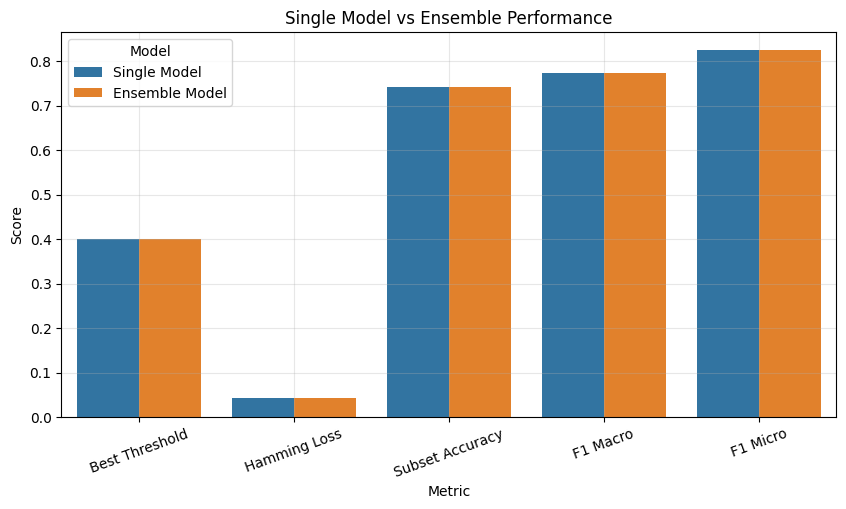

In [10]:
comparison_melted = comparison.melt(id_vars="Metric", var_name="Model", value_name="Score")

plt.figure(figsize=(10,5))
sns.barplot(data=comparison_melted, x="Metric", y="Score", hue="Model")
plt.title("Single Model vs Ensemble Performance")
plt.xticks(rotation=20)
plt.grid(True, alpha=0.3)
plt.show()

## Step 9: Per-Class AUC Improvement

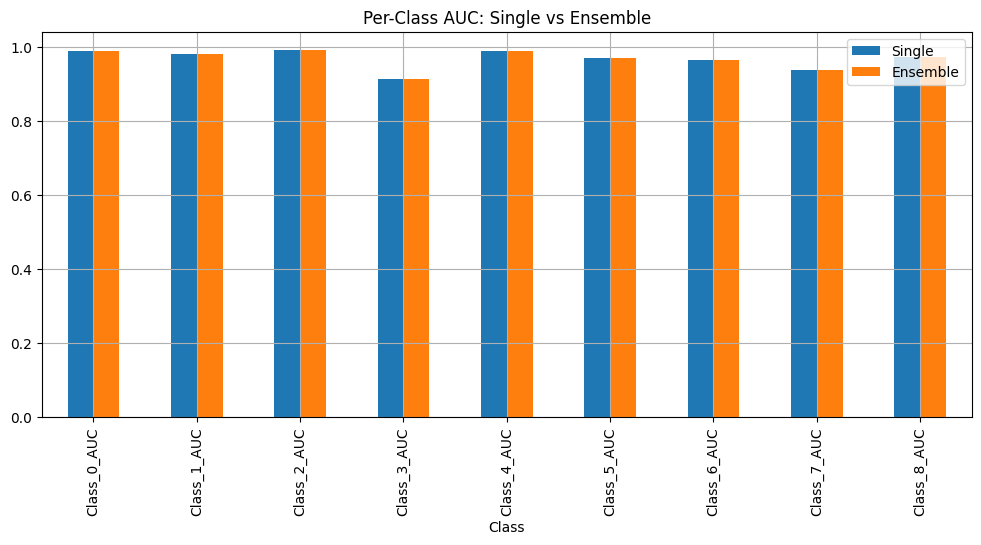

In [11]:
auc_df = pd.DataFrame({
    "Class": list(aucs_single.keys()),
    "Single": list(aucs_single.values()),
    "Ensemble": list(aucs_ensemble.values())
})

auc_df.plot(
    x="Class",
    kind="bar",
    figsize=(12,5),
    title="Per-Class AUC: Single vs Ensemble",
    grid=True
)
plt.show()